In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras import backend as K

from cleverhans.attacks import FastGradientMethod
from cleverhans.utils_keras import KerasModelWrapper

import sys
sys.path.append('../Final_notebook/')
import proj_utils as utils

Using TensorFlow backend.


In [2]:
n_features = 2
n_classes = 4
n_samples = 400
x, y = make_classification(n_samples=n_samples, n_classes=n_classes, n_features=n_features, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1, class_sep=1.4)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
y_train_ohc = to_categorical(y_train)
y_test_ohc = to_categorical(y_test)

Text(0.5, 1.0, 'y_test')

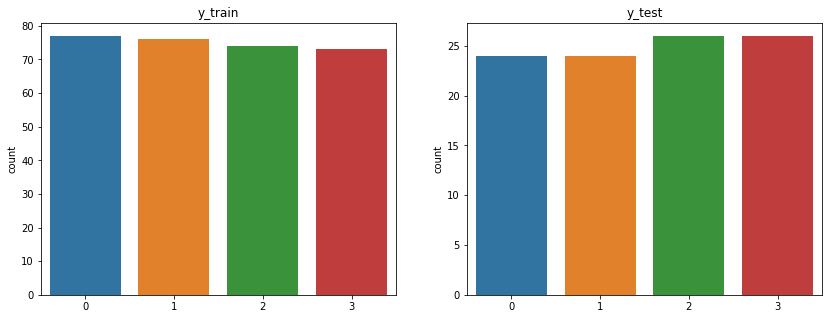

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(y_train, ax=axs[0])
sns.countplot(y_test, ax=axs[1])
axs[0].set_title("y_train")
axs[1].set_title("y_test")

Text(0.5, 1.0, 'x_test')

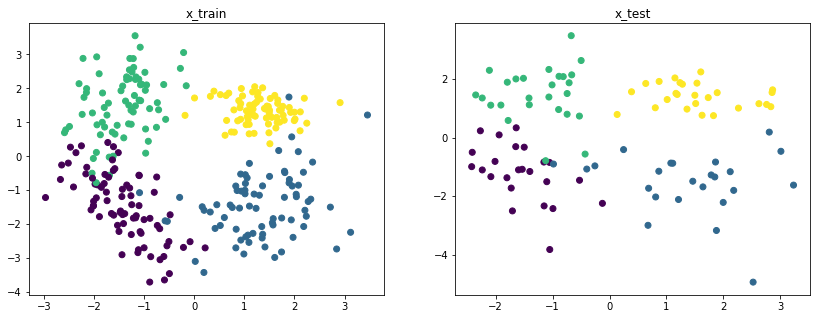

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].scatter(*x_train.T, c=y_train)
axs[1].scatter(*x_test.T, c=y_test)
axs[0].set_title('x_train')
axs[1].set_title('x_test')

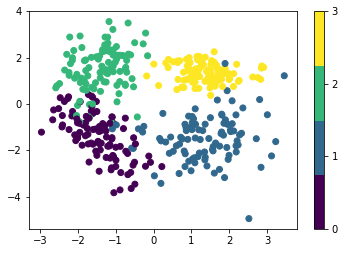

In [6]:
plt.scatter(*x.T, c=y, cmap=plt.cm.get_cmap('viridis', n_classes))
plt.colorbar(ticks=list(range(n_classes)))
(l, r), (d, u) = plt.xlim(), plt.ylim()
bounds = (l, r, d, u)

In [7]:
model = Sequential()
model.add(Dense(10, input_dim=n_features, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(n_classes, activation='softmax', name='Predictions'))

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 66        
_________________________________________________________________
Predictions (Dense)          (None, 4)                 28        
Total params: 124
Trainable params: 124
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(x_train, y_train_ohc, validation_data=(x_test, y_test_ohc), epochs=200, verbose=0)
print(history.history['acc'][-1])
print(history.history['val_acc'][-1])

0.9366666674613953
0.92


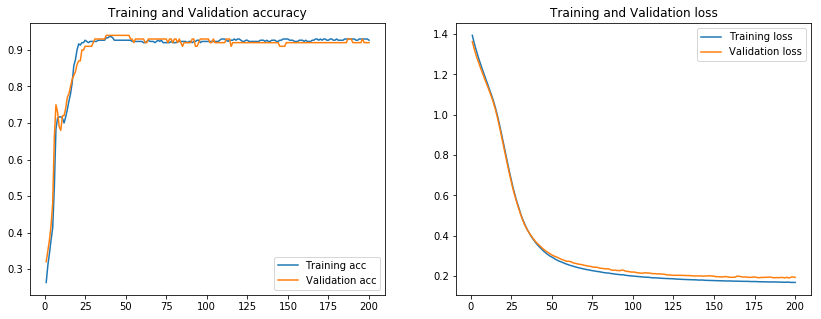

In [11]:
utils.plot_history(history)

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f639f7522b0>)

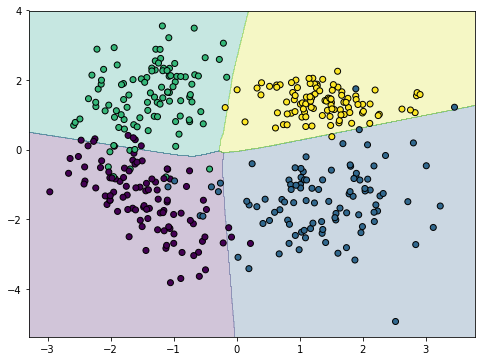

In [12]:
utils.plot_decision_boundary(x, y, model, bounds)

In [13]:
gradients = utils.gradient_loss_wrt_input(x_test, y_test_ohc, model)
gradients_sign = np.sign(gradients)

In [14]:
np.random.seed(42)
ind = np.sort(np.random.choice(np.arange(x_test.shape[0]), size=40))

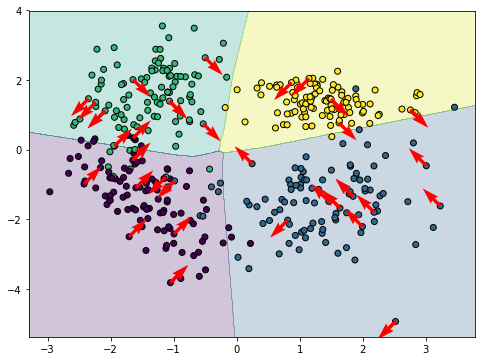

In [15]:
fig, ax = utils.plot_decision_boundary(x, y, model, bounds, steps=2000)
ax.quiver(*x_test[ind].T, *gradients_sign[ind].T, color='red')

In [11]:
ch_model = KerasModelWrapper(model)
fgsm = FastGradientMethod(ch_model, sess=K.get_session())
fgsm_params = {'eps': 0.4}
adv = fgsm.generate_np(x_test, **fgsm_params)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



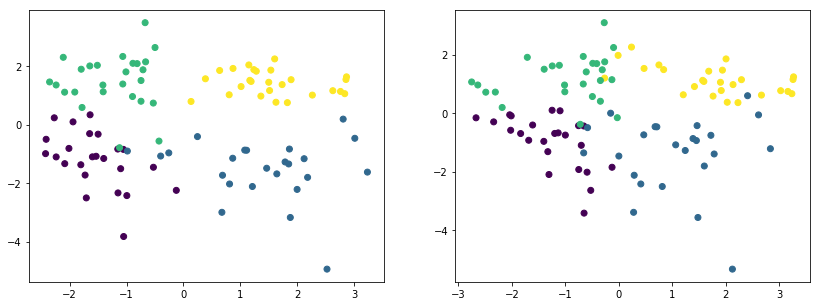

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].scatter(*x_test.T, c=y_test)
axs[1].scatter(*adv.T, c=y_test)

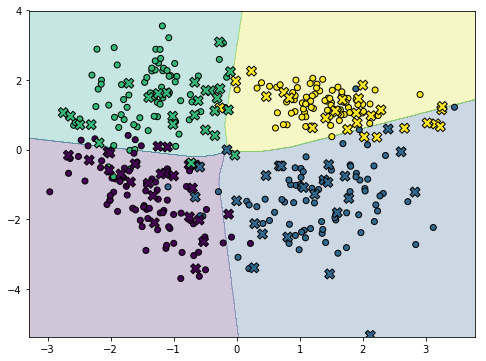

In [26]:
fig, ax = utils.plot_decision_boundary(x, y, model, bounds, x_train=x_train,
                                       y_train=y_train, train_only=True)
ax.scatter(*adv.T, c=y_test, marker='X', edgecolors='k', s=10**2)

In [27]:
model.evaluate(adv, y_test_ohc)

100/100 [==============================] - 0s 31us/step


[0.3842234969139099, 0.83]

In [37]:
n_features = 500
x, y = make_classification(n_samples=2000, n_classes=n_classes, n_features=n_features, n_redundant=0, n_informative=n_features,
                           random_state=42, n_clusters_per_class=1, class_sep=1.4)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=4)
y_train_ohc = to_categorical(y_train)
y_test_ohc = to_categorical(y_test)

Text(0.5, 1.0, 'y_test')

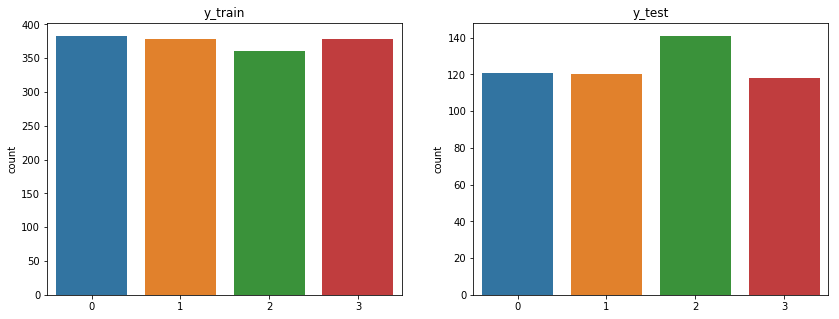

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(y_train, ax=axs[0])
sns.countplot(y_test, ax=axs[1])
axs[0].set_title("y_train")
axs[1].set_title("y_test")

In [40]:
model = Sequential()
model.add(Dense(32, input_dim=n_features, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(n_classes, activation='softmax', name='Predictions'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                16032     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
Predictions (Dense)          (None, 4)                 68        
Total params: 16,628
Trainable params: 16,628
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model.fit(x_train, y_train_ohc, validation_data=(x_test, y_test_ohc), epochs=200, verbose=0)
print(history.history['acc'][-1])
print(history.history['val_acc'][-1])

0.9733333333333334
0.646


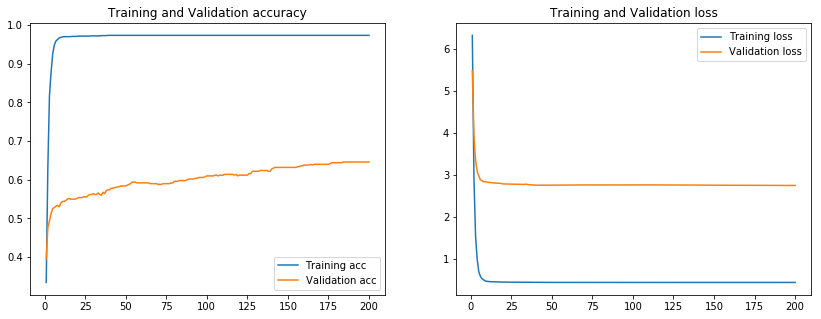

In [42]:
utils.plot_history(history)

In [45]:
ch_model = KerasModelWrapper(model)
fgsm = FastGradientMethod(ch_model, sess=K.get_session())
fgsm_params = {'eps': 0.4}
adv = fgsm.generate_np(x_test, **fgsm_params)

In [46]:
model.evaluate(adv, y_test_ohc)

500/500 [==============================] - 0s 20us/step


[3.5726458053588868, 0.4740000002384186]